<a href="https://colab.research.google.com/github/thinhngo-x/deep-learning/blob/master/TD7_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm.notebook import tqdm

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

In [0]:
def init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

# 1. ResNet

In [0]:
def trainer(train_loader, test_loader, model, use_cuda, loss_fn=nn.CrossEntropyLoss(), epoch=10, rate=1e-3):
    loss_eval = []
    err_eval = []
    #   data = torch.utils.data.DataLoader(dataset, batch_size)
    optimizer = torch.optim.Adam(model.parameters(),lr=rate)
    j = 0
    for i in tqdm(range(epoch)):
        for imgs, labels in train_loader:
            j += 1
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            optimizer.zero_grad()

            output = model(imgs)
            loss = loss_fn(output, labels)
            if j % 500 == 1 :
                loss_eval.append(loss.item())
                err_eval.append(1 - accuracy(test_loader, model, use_cuda))
            loss.backward()

            optimizer.step()
        
    return loss_eval, err_eval

def accuracy(dataloader, model, use_cuda):
    model.eval()
    #   test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    corr = 0
    total = 0
    for imgs, labels in dataloader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        with torch.no_grad():
            output = model(imgs)
            output = [torch.argmax(i) for i in output]
            correct = [i for i,j in zip(output, labels) if i == j]
            corr += len(correct)
            total += len(labels)
    model.train()
    # print(len(correct))
    return(corr / total)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(SimpleBlock, self).__init__()

        assert((stride == 1) or (stride == 2 and planes == in_planes * 2))

        padding = 0
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))

        return out

      
class ResNetBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        assert((stride == 1) or (stride == 2 and planes == in_planes * 2))

        padding = 0
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride=1, padding=1, bias=False)
        if stride == 2: 
            self.shortcut = nn.Conv2d(in_planes, planes, 1, stride=2, padding=0, bias=False)
        else: 
            self.shortcut = nn.Identity()
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out) + self.shortcut(x)
        out = F.relu(self.bn2(out))

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_filters=16, input_dim=3):
        super(ResNet, self).__init__()
        self.in_planes = num_filters

        self.conv1 = nn.Conv2d(input_dim, num_filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters)
		
        layers_resnet = []
        for i in range(len(num_blocks)) :
            if i == 0 :
                planes = self.in_planes
                print(planes)
                layers_resnet.append(self._make_layer(block, planes, num_blocks[i], stride=1))
            else :
                planes = self.in_planes * 2
                print(planes)
                layers_resnet.append(self._make_layer(block, planes, num_blocks[i], stride=2))

        self.resnet = nn.Sequential(*layers_resnet)
		
        self.fc = nn.Sequential(
            nn.Linear(self.in_planes, num_classes),
            nn.LogSoftmax(1)
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []

        if stride != 1 :
            downsample = block(self.in_planes, planes, stride)
            layers.append(downsample)
            num_blocks -= 1
            self.in_planes = planes

        for i in range(num_blocks) :
            layers.append(block(self.in_planes, planes, 1))
            self.in_planes = planes
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.resnet(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# (1 + 2*(1 + 1) + 2*(1 + 1) + 2*(1 + 1) + 2*(1 + 1)) + 1 = 18
def ResNet18(input_dim=3):
    return ResNet(ResNetBlock, [2, 2, 2, 2], input_dim=input_dim)

def PlainNet18(input_dim=3):
    return ResNet(SimpleBlock, [2, 2, 2, 2], input_dim=input_dim)

def ResNet36(input_dim=3):
  return ResNet(ResNetBlock, [4, 4, 4, 4], input_dim=input_dim)

In [0]:
summary(ResNet18(3).cuda(), input_size=(3,32,32), batch_size=32)

16
32
64
128
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 32, 32]             432
       BatchNorm2d-2           [32, 16, 32, 32]              32
            Conv2d-3           [32, 16, 32, 32]           2,304
       BatchNorm2d-4           [32, 16, 32, 32]              32
            Conv2d-5           [32, 16, 32, 32]           2,304
          Identity-6           [32, 16, 32, 32]               0
       BatchNorm2d-7           [32, 16, 32, 32]              32
       ResNetBlock-8           [32, 16, 32, 32]               0
            Conv2d-9           [32, 16, 32, 32]           2,304
      BatchNorm2d-10           [32, 16, 32, 32]              32
           Conv2d-11           [32, 16, 32, 32]           2,304
         Identity-12           [32, 16, 32, 32]               0
      BatchNorm2d-13           [32, 16, 32, 32]              32
      ResNetBlock-14      

In [0]:
summary(PlainNet18(3).cuda(), input_size=(3,32,32), batch_size=32)

16
32
64
128
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 32, 32]             432
       BatchNorm2d-2           [32, 16, 32, 32]              32
            Conv2d-3           [32, 16, 32, 32]           2,304
       BatchNorm2d-4           [32, 16, 32, 32]              32
            Conv2d-5           [32, 16, 32, 32]           2,304
       BatchNorm2d-6           [32, 16, 32, 32]              32
       SimpleBlock-7           [32, 16, 32, 32]               0
            Conv2d-8           [32, 16, 32, 32]           2,304
       BatchNorm2d-9           [32, 16, 32, 32]              32
           Conv2d-10           [32, 16, 32, 32]           2,304
      BatchNorm2d-11           [32, 16, 32, 32]              32
      SimpleBlock-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 32, 16, 16]           4,608
      BatchNorm2d-14      

The more blocks there are, the deeper the network is.

## On CIFAR-10

In [0]:
batch_size=64
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=10000,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model_resnet18 = ResNet18()
model_resnet18.apply(init)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_resnet18.cuda()
losses, val_errs = trainer(trainloader, testloader, model_resnet18, use_cuda, epoch=3)
print(accuracy(testloader, model_resnet18, use_cuda))

16
32
64
128
using cuda



0.7327


In [0]:
model_plainnet18 = PlainNet18()
model_plainnet18.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_plainnet18.cuda()
losses_, val_errs_ = trainer(trainloader, testloader, model_plainnet18, use_cuda, epoch=3)
print(accuracy(testloader, model_plainnet18, use_cuda))


16
32
64
128
using cuda



0.68


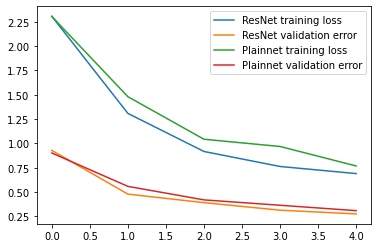

In [0]:
plt.plot(losses, label='ResNet training loss')
plt.plot(val_errs, label='ResNet validation error')
plt.plot(losses_, label='Plainnet training loss')
plt.plot(val_errs_, label='Plainnet validation error')
plt.legend()

ResNet proved to be more efficient than a plain network though they have the number of parameters nearly equivalent (700k vs 690k) and the same depth.

## On FashionMNIST

In [0]:
batch_size=32
transform = transforms.Compose(
    [
     transforms.ToTensor()
])
trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
model_resnet18 = ResNet18(1)
model_resnet18.apply(init)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_resnet18.cuda()
losses, val_errs = trainer(trainloader, testloader, model_resnet18, use_cuda, epoch=3)
print(accuracy(testloader, model_resnet18, use_cuda))

16


32
64
128
using cuda



0.9079


In [0]:
model_plainnet18 = PlainNet18(1)
model_plainnet18.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_plainnet18.cuda()
losses_, val_errs_ = trainer(trainloader, testloader, model_plainnet18, use_cuda, epoch=3)
print(accuracy(testloader, model_plainnet18, use_cuda))

16
32
64
128
using cuda



0.9029


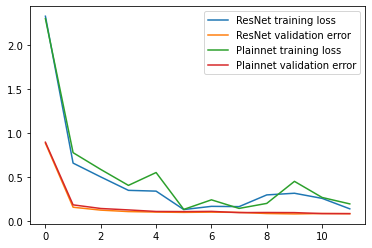

In [0]:
plt.plot(losses, label='ResNet training loss')
plt.plot(val_errs, label='ResNet validation error')
plt.plot(losses_, label='Plainnet training loss')
plt.plot(val_errs_, label='Plainnet validation error')
plt.legend()

On the dataset FashionMNIST, the difference is less visible due to its simplicity and the already efficiency of the plain network on it